In [1]:
import pandas as pd
from pandas import concat
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from sklearn import preprocessing
from tensorflow.keras import backend as K
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, LSTM,GRU,SimpleRNN, Activation
from matplotlib import pyplot
#from sklearn.model_selection import train_test_split

In [2]:
"# convert series to supervised learning\n" 
#windowing of data
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1),
    for i in range(n_in, 0, -1): #startes from n_in and decreses to 0 by decreasing each time -1
     cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
     cols.append(df.shift(-i))
     if i == 0:
       names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
     else:
       names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together\n",
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values\n",
    if dropnan:
      agg.dropna(inplace=True)
    return agg

In [3]:
#def root_mean_squared_error(y_true, y_pred):
 #       return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [4]:
dataset1=pd.read_excel('F:\MS thesis data/Brooklyn.xlsx')
dataset1=dataset1.drop(['Date/Time','Flowd'],axis=1)
dataset1.dropna(inplace=True)

(26302, 3)


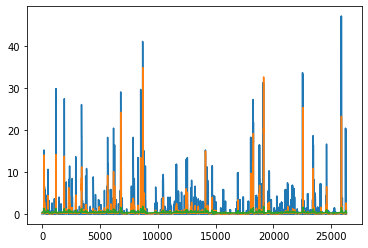

In [5]:
shape=np.shape(dataset1)
print(shape)
pyplot.plot(dataset1)

In [6]:
dataset1

,Cumulative rainfall,Flow,Level
0,0.0,0.172,0.352
1,0.0,0.180,0.356
2,0.0,0.180,0.356
3,0.0,0.189,0.360
4,0.0,0.189,0.360
...,...,...,...
26297,0.0,0.025,0.232
26298,0.0,0.023,0.228
26299,0.0,0.023,0.228
26300,0.0,0.023,0.228


In [7]:
print('The std of original data is ' + str(np.std(dataset1)))

The std of original data is Cumulative rainfall     2.872616
Flow                    1.306642
Level                   0.147238
dtype: float64


In [8]:
#Normalizing and removing outlier from Dataset
#Outliers removel
num=int((shape[0]*0.03)/2)
dataset=dataset1.values
#dataset=np.array(dataset)
#pyplot.plot(dataset[:,0])
#pyplot.plot(dataset[:,1])
#pyplot.plot(dataset[:,2])
count=0
#for j in range(num):
while(count<num):
    
    maxi=dataset.max(axis=0)
#    print(maxi)
    ind1=np.argwhere(dataset[:,0]== maxi[0])
    ind2=np.argwhere(dataset[:,1]== maxi[1])
    ind3=np.argwhere(dataset[:,2]== maxi[2])
    ind=np.append(ind1,ind2)
    ind=np.append(ind,ind3)
    index=[]
    for i in ind:
        if i not in index:
            index.append(i)
    count=count+len(index)
    dataset=np.delete(dataset,index,axis=0) 
#pyplot.plot(dataset[:,0])
#pyplot.plot(dataset[:,1])
#pyplot.plot(dataset[:,2])    
    
count=0
#for j in range(num):
while(count<num):
    
    mini=dataset.min(axis=0)
#    print(mini)
    ind1=np.argwhere(dataset[:,0]== mini[0])
    ind2=np.argwhere(dataset[:,1]== mini[1])
    ind3=np.argwhere(dataset[:,2]== mini[2])
    ind=np.append(ind1,ind2)
    ind=np.append(ind,ind3)
    index=[]
    for i in ind:
        if i not in index:
            index.append(i)
    count=count+len(index)
    dataset=np.delete(dataset,index,axis=0) 
#pyplot.plot(dataset[:,0])
#pyplot.plot(dataset[:,1])
#pyplot.plot(dataset[:,2]) 
print('The std of cleaned data is ' +str(np.std(dataset)))
min_max_scaler = preprocessing.MinMaxScaler()   #scaling values
dataset = min_max_scaler.fit_transform(dataset)

The std of cleaned data is 1.626639593959813


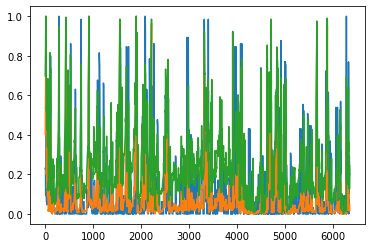

In [9]:
pyplot.plot(dataset)

In [10]:
dataset=pd.DataFrame(dataset)
dataset.dropna(inplace=True)
dataset.columns=['rain','flow','level']
n_hours =6
out_hour=1
values =dataset.values
values = values.astype('float32')
reframed = series_to_supervised(values, n_hours, out_hour)
print(reframed.shape)
trainx_column=n_hours*3
pred_columns=reframed.shape[1]-trainx_column
for i in range(out_hour):
    reframed.drop(reframed.columns[[-3-i,-2-i]], axis=1, inplace=True)
print(reframed.head())
values = reframed.values
train_size  = int(len(dataset) * 0.50)
val_size=int(len(dataset) * 0.75)
train_X, train_y = values[0:train_size, :-out_hour], values[0:train_size,-out_hour: ]
val_X, val_y=values[train_size:val_size, :-out_hour], values[train_size:val_size,-out_hour: ]
test_X, test_y = values[val_size:, :-out_hour], values[val_size:,-out_hour:]
#for last hour
#train_X, train_y = values[train_size:val_size, :-out_hour], values[train_size:val_size,-1 ]  #for only last hour
#val_X, val_y=values[train_size:val_size, :-out_hour], values[train_size:val_size,-1 ]
#test_X, test_y = values[val_size:, :-out_hour], values[val_size:,-1]
print(train_X, train_y)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


(6345, 21)
    var1(t-6)  var2(t-6)  var3(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
6    0.230769   0.401887   0.699029   0.230769   0.438261   0.723301   
7    0.230769   0.438261   0.723301   0.230769   0.476275   0.747573   
8    0.230769   0.476275   0.747573   0.230769   0.500068   0.762136   
9    0.230769   0.500068   0.762136   0.230769   0.524545   0.776699   
10   0.230769   0.524545   0.776699   0.215385   0.524545   0.776699   

    var1(t-4)  var2(t-4)  var3(t-4)  var1(t-3)  var2(t-3)  var3(t-3)  \
6    0.230769   0.476275   0.747573   0.230769   0.500068   0.762136   
7    0.230769   0.500068   0.762136   0.230769   0.524545   0.776699   
8    0.230769   0.524545   0.776699   0.215385   0.524545   0.776699   
9    0.215385   0.524545   0.776699   0.123077   0.549980   0.791262   
10   0.123077   0.549980   0.791262   0.092308   0.603309   0.820388   

    var1(t-2)  var2(t-2)  var3(t-2)  var1(t-1)  var2(t-1)  var3(t-1)   var3(t)  
6    0.230769   0.524545   0.776699   0.21

In [11]:
print(train_X, train_y)

[[[0.23076923 0.40188706 0.69902915 ... 0.21538462 0.5245453  0.776699  ]]

 [[0.23076923 0.43826064 0.723301   ... 0.12307692 0.5499795  0.79126215]]

 [[0.23076923 0.47627512 0.74757284 ... 0.09230769 0.60330915 0.8203884 ]]

 ...

 [[0.         0.04321072 0.23300971 ... 0.         0.04321072 0.23300971]]

 [[0.         0.04321072 0.23300971 ... 0.         0.04498838 0.23786408]]

 [[0.         0.04321072 0.23300971 ... 0.         0.04662929 0.24271844]]] [[0.79126215]
 [0.8203884 ]
 [0.8446602 ]
 ...
 [0.23786408]
 [0.24271844]
 [0.24757281]]


In [12]:
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(3175, 1, 18) (3175, 1) (1588, 1, 18) (1588, 1)


In [13]:
randomState = 46
np.random.seed(randomState)
#tensorflow.random.set_random_seed(randomState)
tensorflow.random.set_seed(randomState)
model = Sequential()
model.add(SimpleRNN(15,input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(22))
#model.add(Activation('relu'))    
model.add(Dense(out_hour,activation = "sigmoid"))
opt=tensorflow.keras.optimizers.Adam(learning_rate=0.001)
#    opt=tensorflow.keras.optimizers.Adam(learning_rate=0.00075)
model.compile(loss='mae', optimizer=opt,metrics=['mse','mae',tensorflow.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_X, train_y,validation_data=(val_X, val_y), epochs=500, batch_size=100,verbose=1,shuffle=False)
score = model.evaluate(test_X, test_y, verbose=0)
out=model.predict(test_X)

Train on 3175 samples, validate on 1588 samples
Epoch 1/500
3175/3175 [==============================] - 1s 343us/sample - loss: 0.2276 - mse: 0.0646 - mae: 0.2276 - root_mean_squared_error: 0.2541 - val_loss: 0.2302 - val_mse: 0.0683 - val_mae: 0.2302 - val_root_mean_squared_error: 0.2614
Epoch 2/500
3175/3175 [==============================] - 0s 21us/sample - loss: 0.1942 - mse: 0.0511 - mae: 0.1942 - root_mean_squared_error: 0.2260 - val_loss: 0.2060 - val_mse: 0.0570 - val_mae: 0.2060 - val_root_mean_squared_error: 0.2388
Epoch 3/500
3175/3175 [==============================] - 0s 19us/sample - loss: 0.1764 - mse: 0.0451 - mae: 0.1764 - root_mean_squared_error: 0.2125 - val_loss: 0.1890 - val_mse: 0.0494 - val_mae: 0.1890 - val_root_mean_squared_error: 0.2222
Epoch 4/500
3175/3175 [==============================] - 0s 20us/sample - loss: 0.1619 - mse: 0.0394 - mae: 0.1619 - root_mean_squared_error: 0.1984 - val_loss: 0.1735 - val_mse: 0.0421 - val_mae: 0.1735 - val_root_mean_squar

3175/3175 [==============================] - 0s 20us/sample - loss: 0.0261 - mse: 0.0024 - mae: 0.0261 - root_mean_squared_error: 0.0494 - val_loss: 0.0342 - val_mse: 0.0038 - val_mae: 0.0342 - val_root_mean_squared_error: 0.0617
Epoch 68/500
3175/3175 [==============================] - 0s 20us/sample - loss: 0.0260 - mse: 0.0024 - mae: 0.0260 - root_mean_squared_error: 0.0492 - val_loss: 0.0340 - val_mse: 0.0038 - val_mae: 0.0340 - val_root_mean_squared_error: 0.0616
Epoch 69/500
3175/3175 [==============================] - 0s 20us/sample - loss: 0.0258 - mse: 0.0024 - mae: 0.0258 - root_mean_squared_error: 0.0491 - val_loss: 0.0338 - val_mse: 0.0038 - val_mae: 0.0338 - val_root_mean_squared_error: 0.0616
Epoch 70/500
3175/3175 [==============================] - 0s 20us/sample - loss: 0.0257 - mse: 0.0024 - mae: 0.0257 - root_mean_squared_error: 0.0490 - val_loss: 0.0336 - val_mse: 0.0038 - val_mae: 0.0336 - val_root_mean_squared_error: 0.0614
Epoch 71/500
3175/3175 [=================

Epoch 134/500
3175/3175 [==============================] - 0s 20us/sample - loss: 0.0224 - mse: 0.0023 - mae: 0.0224 - root_mean_squared_error: 0.0482 - val_loss: 0.0280 - val_mse: 0.0035 - val_mae: 0.0280 - val_root_mean_squared_error: 0.0588
Epoch 135/500
3175/3175 [==============================] - 0s 20us/sample - loss: 0.0223 - mse: 0.0023 - mae: 0.0223 - root_mean_squared_error: 0.0481 - val_loss: 0.0281 - val_mse: 0.0035 - val_mae: 0.0281 - val_root_mean_squared_error: 0.0591
Epoch 136/500
3175/3175 [==============================] - 0s 20us/sample - loss: 0.0223 - mse: 0.0023 - mae: 0.0223 - root_mean_squared_error: 0.0482 - val_loss: 0.0281 - val_mse: 0.0035 - val_mae: 0.0281 - val_root_mean_squared_error: 0.0591
Epoch 137/500
3175/3175 [==============================] - 0s 20us/sample - loss: 0.0223 - mse: 0.0023 - mae: 0.0223 - root_mean_squared_error: 0.0482 - val_loss: 0.0280 - val_mse: 0.0035 - val_mae: 0.0280 - val_root_mean_squared_error: 0.0590
Epoch 138/500
3175/3175 

3175/3175 [==============================] - 0s 21us/sample - loss: 0.0211 - mse: 0.0023 - mae: 0.0211 - root_mean_squared_error: 0.0479 - val_loss: 0.0259 - val_mse: 0.0033 - val_mae: 0.0259 - val_root_mean_squared_error: 0.0578
Epoch 200/500
3175/3175 [==============================] - ETA: 0s - loss: 0.0393 - mse: 0.0062 - mae: 0.0393 - root_mean_squared_error: 0.078 - 0s 21us/sample - loss: 0.0211 - mse: 0.0023 - mae: 0.0211 - root_mean_squared_error: 0.0479 - val_loss: 0.0259 - val_mse: 0.0033 - val_mae: 0.0259 - val_root_mean_squared_error: 0.0577
Epoch 201/500
3175/3175 [==============================] - 0s 22us/sample - loss: 0.0210 - mse: 0.0023 - mae: 0.0210 - root_mean_squared_error: 0.0478 - val_loss: 0.0259 - val_mse: 0.0033 - val_mae: 0.0259 - val_root_mean_squared_error: 0.0577
Epoch 202/500
3175/3175 [==============================] - 0s 21us/sample - loss: 0.0210 - mse: 0.0023 - mae: 0.0210 - root_mean_squared_error: 0.0478 - val_loss: 0.0259 - val_mse: 0.0033 - val_ma

Epoch 266/500
3175/3175 [==============================] - 0s 40us/sample - loss: 0.0206 - mse: 0.0023 - mae: 0.0206 - root_mean_squared_error: 0.0476 - val_loss: 0.0251 - val_mse: 0.0033 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0577
Epoch 267/500
3175/3175 [==============================] - 0s 40us/sample - loss: 0.0206 - mse: 0.0023 - mae: 0.0206 - root_mean_squared_error: 0.0476 - val_loss: 0.0250 - val_mse: 0.0033 - val_mae: 0.0250 - val_root_mean_squared_error: 0.0576
Epoch 268/500
3175/3175 [==============================] - 0s 23us/sample - loss: 0.0206 - mse: 0.0023 - mae: 0.0206 - root_mean_squared_error: 0.0476 - val_loss: 0.0251 - val_mse: 0.0033 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0577
Epoch 269/500
3175/3175 [==============================] - 0s 21us/sample - loss: 0.0206 - mse: 0.0023 - mae: 0.0206 - root_mean_squared_error: 0.0476 - val_loss: 0.0250 - val_mse: 0.0033 - val_mae: 0.0250 - val_root_mean_squared_error: 0.0576
Epoch 270/500
3175/3175 

Epoch 333/500
3175/3175 [==============================] - 0s 70us/sample - loss: 0.0202 - mse: 0.0023 - mae: 0.0202 - root_mean_squared_error: 0.0475 - val_loss: 0.0245 - val_mse: 0.0033 - val_mae: 0.0245 - val_root_mean_squared_error: 0.0574
Epoch 334/500
3175/3175 [==============================] - 0s 26us/sample - loss: 0.0203 - mse: 0.0023 - mae: 0.0203 - root_mean_squared_error: 0.0475 - val_loss: 0.0244 - val_mse: 0.0033 - val_mae: 0.0244 - val_root_mean_squared_error: 0.0573
Epoch 335/500
3175/3175 [==============================] - 0s 22us/sample - loss: 0.0203 - mse: 0.0023 - mae: 0.0203 - root_mean_squared_error: 0.0475 - val_loss: 0.0244 - val_mse: 0.0033 - val_mae: 0.0244 - val_root_mean_squared_error: 0.0574
Epoch 336/500
3175/3175 [==============================] - 0s 23us/sample - loss: 0.0203 - mse: 0.0023 - mae: 0.0203 - root_mean_squared_error: 0.0475 - val_loss: 0.0245 - val_mse: 0.0033 - val_mae: 0.0245 - val_root_mean_squared_error: 0.0574
Epoch 337/500
3175/3175 

Epoch 400/500
3175/3175 [==============================] - 0s 35us/sample - loss: 0.0200 - mse: 0.0022 - mae: 0.0200 - root_mean_squared_error: 0.0474 - val_loss: 0.0242 - val_mse: 0.0033 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0572
Epoch 401/500
3175/3175 [==============================] - 0s 33us/sample - loss: 0.0201 - mse: 0.0023 - mae: 0.0201 - root_mean_squared_error: 0.0475 - val_loss: 0.0242 - val_mse: 0.0033 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0572
Epoch 402/500
3175/3175 [==============================] - 0s 34us/sample - loss: 0.0201 - mse: 0.0023 - mae: 0.0201 - root_mean_squared_error: 0.0475 - val_loss: 0.0242 - val_mse: 0.0033 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0571
Epoch 403/500
3175/3175 [==============================] - 0s 34us/sample - loss: 0.0201 - mse: 0.0023 - mae: 0.0201 - root_mean_squared_error: 0.0475 - val_loss: 0.0242 - val_mse: 0.0033 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0571
Epoch 404/500
3175/3175 

Epoch 467/500
3175/3175 [==============================] - 0s 30us/sample - loss: 0.0199 - mse: 0.0022 - mae: 0.0199 - root_mean_squared_error: 0.0474 - val_loss: 0.0240 - val_mse: 0.0033 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0571
Epoch 468/500
3175/3175 [==============================] - 0s 29us/sample - loss: 0.0200 - mse: 0.0022 - mae: 0.0200 - root_mean_squared_error: 0.0474 - val_loss: 0.0241 - val_mse: 0.0033 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0572
Epoch 469/500
3175/3175 [==============================] - 0s 29us/sample - loss: 0.0199 - mse: 0.0022 - mae: 0.0199 - root_mean_squared_error: 0.0474 - val_loss: 0.0240 - val_mse: 0.0033 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0572
Epoch 470/500
3175/3175 [==============================] - 0s 64us/sample - loss: 0.0199 - mse: 0.0022 - mae: 0.0199 - root_mean_squared_error: 0.0474 - val_loss: 0.0240 - val_mse: 0.0033 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0573
Epoch 471/500
3175/3175 

The testing MAE loss is: 0.022685139
The testing MSE loss is: 0.0028908753
The testing RMSE loss is: 0.05376686


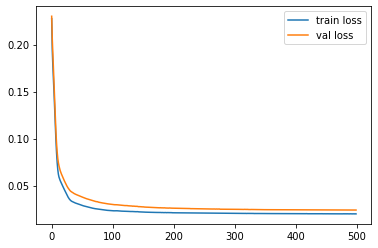

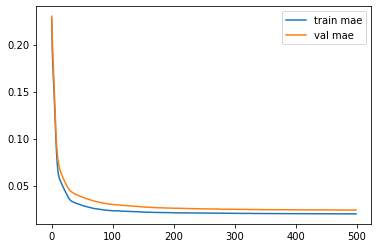

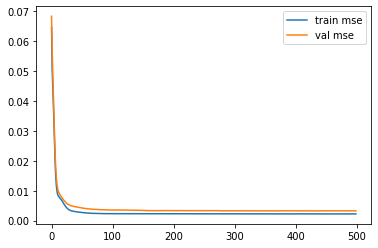

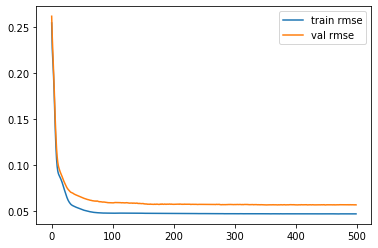

In [14]:
print('The testing MAE loss is:', str(score[2]))
print('The testing MSE loss is:', str(score[1]))
print('The testing RMSE loss is:', str(score[3]))
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='val loss')
pyplot.legend()
pyplot.show()
pyplot.plot(history.history['mae'],label='train mae')
pyplot.plot(history.history['val_mae'],label='val mae')
pyplot.legend()
pyplot.show()
pyplot.plot(history.history['mse'],label='train mse')
pyplot.plot(history.history['val_mse'],label='val mse')
pyplot.legend()
pyplot.show()
pyplot.plot(history.history['root_mean_squared_error'],label='train rmse')
pyplot.plot(history.history['val_root_mean_squared_error'],label='val rmse')
pyplot.legend()
pyplot.show()

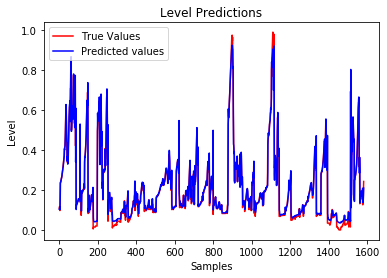

In [15]:
pyplot.plot(test_y,color='red', label='True Values')
pyplot.plot(out,color='blue',label='Predicted values')
pyplot.title("Level Predictions")
pyplot.legend(loc='upper left')
pyplot.xlabel("Samples")
pyplot.ylabel("Level")
pyplot.show()

In [16]:
dataset_test=pd.read_excel('F:\MS thesis data/Hopper Crossing.xlsx')
dataset_test=dataset_test.drop(['Date/Time','Flowd'],axis=1)
dataset_test.dropna(inplace=True)


(26285, 3)


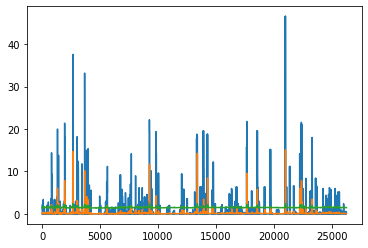

In [17]:
shape=np.shape(dataset_test)
print(shape)
pyplot.plot(dataset_test)


In [18]:
dataset_test

,Cumulative rainfall,Flow,Level
0,0.0,0.093,1.50
1,0.0,0.093,1.50
2,0.0,0.093,1.50
3,0.0,0.093,1.50
4,0.0,0.093,1.50
...,...,...,...
26280,0.2,0.080,1.49
26281,0.2,0.080,1.49
26282,0.2,0.080,1.49
26283,0.2,0.080,1.49


In [19]:
print('The std of original data is ' + str(np.std(dataset_test)))

The std of original data is Cumulative rainfall    2.451640
Flow                   0.520832
Level                  0.083204
dtype: float64


In [20]:
#Normalizing and removing outlier from Dataset
#Outliers removel
num=int((shape[0]*0.03)/2)
dataset_test=dataset_test.values
#dataset=np.array(dataset)
#pyplot.plot(dataset[:,0])
#pyplot.plot(dataset[:,1])
#pyplot.plot(dataset[:,2])
count=0
#for j in range(num):
while(count<num):
    
    maxi=dataset_test.max(axis=0)
#    print(maxi)
    ind1=np.argwhere(dataset_test[:,0]== maxi[0])
    ind2=np.argwhere(dataset_test[:,1]== maxi[1])
    ind3=np.argwhere(dataset_test[:,2]== maxi[2])
    ind=np.append(ind1,ind2)
    ind=np.append(ind,ind3)
    index=[]
    for i in ind:
        if i not in index:
            index.append(i)
    count=count+len(index)
    dataset_test=np.delete(dataset_test,index,axis=0) 
#pyplot.plot(dataset[:,0])
#pyplot.plot(dataset[:,1])
#pyplot.plot(dataset[:,2])    
    
count=0
#for j in range(num):
while(count<num):
    
    mini=dataset_test.min(axis=0)
#    print(mini)
    ind1=np.argwhere(dataset_test[:,0]== mini[0])
    ind2=np.argwhere(dataset_test[:,1]== mini[1])
    ind3=np.argwhere(dataset_test[:,2]== mini[2])
    ind=np.append(ind1,ind2)
    ind=np.append(ind,ind3)
    index=[]
    for i in ind:
        if i not in index:
            index.append(i)
    count=count+len(index)
    dataset_test=np.delete(dataset_test,index,axis=0) 
#pyplot.plot(dataset[:,0])
#pyplot.plot(dataset[:,1])
#pyplot.plot(dataset[:,2]) 
print('The std of cleaned data is ' +str(np.std(dataset_test)))
min_max_scaler = preprocessing.MinMaxScaler()   #scaling values
dataset_test = min_max_scaler.fit_transform(dataset_test)

The std of cleaned data is 1.5154548293543502


In [21]:
dataset=pd.DataFrame(dataset)
dataset.dropna(inplace=True)
dataset.columns=['rain','flow','level']
n_hours =6
out_hour=1
values =dataset.values
values = values.astype('float32')
reframed = series_to_supervised(values, n_hours, out_hour)
print(reframed.shape)
trainx_column=n_hours*3
pred_columns=reframed.shape[1]-trainx_column
for i in range(out_hour):
    reframed.drop(reframed.columns[[-3-i,-2-i]], axis=1, inplace=True)
print(reframed.head())
values = reframed.values

#one hour
#test_X, test_y = values[:, :-out_hour], values[:,-1]


test_X, test_y = values[:, :-out_hour], values[:, -out_hour: ]


test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))





(6345, 21)
    var1(t-6)  var2(t-6)  var3(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
6    0.230769   0.401887   0.699029   0.230769   0.438261   0.723301   
7    0.230769   0.438261   0.723301   0.230769   0.476275   0.747573   
8    0.230769   0.476275   0.747573   0.230769   0.500068   0.762136   
9    0.230769   0.500068   0.762136   0.230769   0.524545   0.776699   
10   0.230769   0.524545   0.776699   0.215385   0.524545   0.776699   

    var1(t-4)  var2(t-4)  var3(t-4)  var1(t-3)  var2(t-3)  var3(t-3)  \
6    0.230769   0.476275   0.747573   0.230769   0.500068   0.762136   
7    0.230769   0.500068   0.762136   0.230769   0.524545   0.776699   
8    0.230769   0.524545   0.776699   0.215385   0.524545   0.776699   
9    0.215385   0.524545   0.776699   0.123077   0.549980   0.791262   
10   0.123077   0.549980   0.791262   0.092308   0.603309   0.820388   

    var1(t-2)  var2(t-2)  var3(t-2)  var1(t-1)  var2(t-1)  var3(t-1)   var3(t)  
6    0.230769   0.524545   0.776699   0.21

In [22]:
score = model.evaluate(test_X, test_y, verbose=0)
out=model.predict(test_X)

In [23]:
print('The testing MAE loss is:', str(score[2]))
print('The testing MSE loss is:', str(score[1]))
print('The testing RMSE loss is:', str(score[3]))

The testing MAE loss is: 0.021560963
The testing MSE loss is: 0.002671243
The testing RMSE loss is: 0.051684067


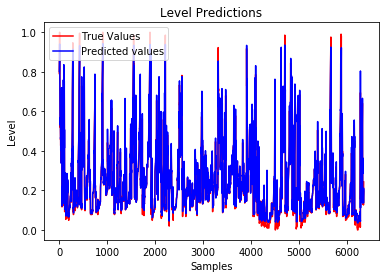

In [24]:
pyplot.plot(test_y,color='red', label='True Values')
pyplot.plot(out,color='blue',label='Predicted values')
pyplot.title("Level Predictions")
pyplot.legend(loc='upper left')
pyplot.xlabel("Samples")
pyplot.ylabel("Level")
pyplot.show()